In [1]:
!pip install datasets
!pip install transformers
!pip install pysentimiento

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
from pysentimiento import create_analyzer
import pandas as pd
import numpy as np
import operator
import sklearn.metrics as metrics
import torch
import random
from collections import defaultdict
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import string
import re
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['hate_speech','Not hate_speech'], yticklabels=['hate_speech', 'Not hate_speech'],annot_kws={"size": 14})
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted labels', fontsize=14)
    plt.ylabel('True labels', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


def evaluate_model(df):
    y_true = df['hate_speech']
    y_pred = df['predictions']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(classification_report(y_true, y_pred))
    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score_macro": macro_f1,
        "confusion_matrix": conf_matrix
    }

In [15]:
sentiment_analyzer = create_analyzer("sentiment", lang="es")
def analyze_sentiment(text):
    result = sentiment_analyzer.predict(text.lower())
    return result.output

def error_analysis_sentiment(df):
    false_positives = df[(df['predictions'] == 1) & (df['hate_speech'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['hate_speech'] == 1)]

    sentiment_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        sentiment = analyze_sentiment(text)
        sentiment_counts['FP'][sentiment] += 1

    for text in (false_negatives['text']):
        sentiment = analyze_sentiment(text)
        sentiment_counts['FN'][sentiment] += 1

    return sentiment_counts

In [16]:
irony_analyzer = create_analyzer("irony", lang="es")
def analyze_irony(text):
    result = irony_analyzer.predict(text.lower())
    return result.output

def error_analysis_irony(df):
    false_positives = df[(df['predictions'] == 1) & (df['hate_speech'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['hate_speech'] == 1)]

    irony_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        irony = analyze_irony(text)
        irony_counts['FP'][irony] += 1

    for text in (false_negatives['text']):
        irony = analyze_irony(text)
        irony_counts['FN'][irony] += 1

    return irony_counts

In [17]:
emotion_analyzer = create_analyzer("emotion", lang="es")
def analyze_emotion(text):
    result = emotion_analyzer.predict(text.lower())
    return result.output

def error_analysis_emotion(df):
    false_positives = df[(df['predictions'] == 1) & (df['hate_speech'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['hate_speech'] == 1)]

    emotion_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        emotion = analyze_emotion(text)
        emotion_counts['FP'][emotion] += 1

    for text in (false_negatives['text']):
        emotion = analyze_emotion(text)
        emotion_counts['FN'][emotion] += 1

    return emotion_counts

In [18]:
pos_analyzer = create_analyzer("pos", lang="es")
def analyze_pos(text):
    result = pos_analyzer.predict(text.lower())
    return result.labels

def error_analysis_pos(df):
    false_positives = df[(df['predictions'] == 1) & (df['hate_speech'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['hate_speech'] == 1)]

    pos_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        pos_tags = analyze_pos(text)
        for pos in pos_tags:
            pos_counts['FP'][pos] += 1

    for text in (false_negatives['text']):
        pos_tags = analyze_pos(text)
        for pos in pos_tags:
            pos_counts['FN'][pos] += 1

    return pos_counts

In [19]:
ner_analyzer = create_analyzer("ner", lang="es")
def analyze_ner(text):
    result = ner_analyzer.predict(text.lower())
    return result.labels

def error_analysis_ner(df):
    false_positives = df[(df['predictions'] == 1) & (df['hate_speech'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['hate_speech'] == 1)]

    ner_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        ner_tags = analyze_ner(text)
        for ner in ner_tags:
            ner_counts['FP'][ner] += 1

    for text in (false_negatives['text']):
        ner_tags = analyze_ner(text)
        for ner in ner_tags:
            ner_counts['FN'][ner] += 1

    return ner_counts

In [ ]:
def plot_wordcloud(texts, title):
    stop_words = set(stopwords.words('spanish') + list(string.punctuation) + ['http', 'https', 't.co'])

    words = word_tokenize(" ".join(texts).lower())

    words_filtered = [word for word in words if word not in stop_words]
    word_freq = Counter(words_filtered)
    print("Las 25 palabras más comunes y su núm de apariciones:")
    print(word_freq.most_common(25))

    words_filtered = re.compile(
        r"((?<=[^a-zA-Z0-9])(?:https?\:\/\/|[a-zA-Z0-9]{1,}\.{1}|\b)(?:\w{1,}\.{1}){1,5}(?:com|co|org|edu|gov|uk|net|ca|de|jp|fr|au|us|ru|ch|it|nl|se|no|es|mil|iq|io|ac|ly|sm){1}(?:\/[a-zA-Z0-9]{1,})*)"
    ).sub("", " ".join(words_filtered))


    wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(words_filtered)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [21]:
from transformers import AutoTokenizer
from collections import Counter
import numpy as np

def vocab_coverage(texts, model_name, verbose=True):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    total_tokens = []
    oov_tokens = []

    for text in texts:
        tokens = tokenizer.tokenize(text.lower())
        total_tokens.extend(tokens)

        for token in tokens:
            if tokenizer.convert_tokens_to_ids(token) == tokenizer.unk_token_id:
                oov_tokens.append(token)

    total_count = len(total_tokens)
    oov_count = len(oov_tokens)
    coverage = 100 * (1 - oov_count / total_count) if total_count > 0 else 0

    if verbose:
        print(f"Modelo: {model_name}")
        print(f"Tokens totales: {total_count}")
        print(f"Tokens OOV: {oov_count}")
        print(f"Coverage del vocabulario: {coverage:.2f}%")
        print(f"Top 10 OOV tokens más frecuentes: {Counter(oov_tokens).most_common(10)}")

    return {
        'model': model_name,
        'coverage': coverage,
        'total_tokens': total_count,
        'oov_tokens': oov_count,
        'top_oov': Counter(oov_tokens).most_common(20)
    }


In [22]:
import pandas as pd

df_test = pd.read_csv("semeval2019_es_test.csv", delimiter=",", names=['id','text','hate_speech','TR','AG'], header=0)

df_robertuito = pd.read_csv("predictions_test_robertuito.csv", delimiter=",")
df_robertuito_4epoch = pd.read_csv("predictions_test_robertuito4epoch.csv", delimiter=",")
df_zero_shot = pd.read_csv("predicciones_zero_shot_semeval_test_lower_preprocess_without_emojis_and_url.csv", delimiter=",", header=None, names=['predictions'])

print(df_test.head())
print(df_robertuito.head())
print(df_robertuito_4epoch.head())
print(df_zero_shot.head())


assert len(df_test) == len(df_robertuito), "El número de predicciones no coincide con el número de textos en el CSV"
assert len(df_test) == len(df_robertuito_4epoch), "El número de predicciones no coincide con el número de textos en el CSV"
assert len(df_test) == len(df_zero_shot), "El número de predicciones no coincide con el número de textos en el CSV"




      id                                               text  hate_speech  TR  \
0  31494     @jlmanavasques Tu eres un hijo de la gran puta            0   0   
1  32461  #EnCampañaM4 Y ellos que llevan humillando al ...            0   0   
2  33228  @Barbijaputa Tú sí q das vergüenza diciendo q ...            0   0   
3  31699  Vieja de mierda, te mereces todo lo que esta m...            1   1   
4  33806  @KarenB612 @SebaCaro8 Puta guede ql, callate p...            1   1   

   AG  
0   0  
1   0  
2   0  
3   1  
4   1  
   predictions
0            0
1            0
2            0
3            1
4            0
   predictions
0            0
1            0
2            0
3            1
4            0
   predictions
0            0
1            0
2            0
3            1
4            0


-----------------------------------
-----------------------------------
-----------------------------------
Evaluación para robertuito:
-----------------------------------
-----------------------------------

Métricas:

              precision    recall  f1-score   support

           0       0.87      0.80      0.84       940
           1       0.75      0.83      0.79       660

    accuracy                           0.81      1600
   macro avg       0.81      0.82      0.81      1600
weighted avg       0.82      0.81      0.82      1600

Accuracy: 0.8144
Precision: 0.7476
Recall: 0.8303
Macro F1 Score: 0.8112


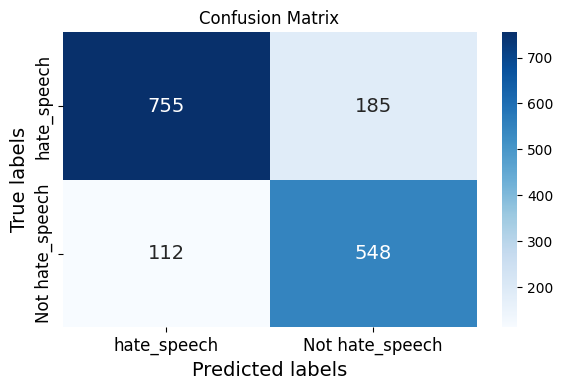

-----------------------------------
-----------------------------------

Análisis de Sentimientos:

Sentimientos en Falsos Positivos:
POS: 11
NEG: 144
NEU: 30
-----------------------------------
Sentimientos en Falsos Negativos:
NEG: 92
POS: 9
NEU: 11
-----------------------------------
-----------------------------------

Análisis de Ironia:

Ironía en Falsos Positivos:
ironic: 51
not ironic: 134
-----------------------------------
Ironía en Falsos Negativos:
not ironic: 95
ironic: 17
-----------------------------------
-----------------------------------

Análisis de Emocion:

Emociones en Falsos Positivos:
others: 73
anger: 102
joy: 7
surprise: 1
sadness: 2
-----------------------------------
Emociones en Falsos Negativos:
anger: 70
others: 33
joy: 6
sadness: 2
surprise: 1
-----------------------------------
-----------------------------------

Análisis de NER (Named Entity Recognition):

NER en Falsos Positivos:
O: 5751
B-USER: 215
B-PER: 37
I-PER: 10
B-OTHER: 68
B-GROUP: 6
B-LOC: 

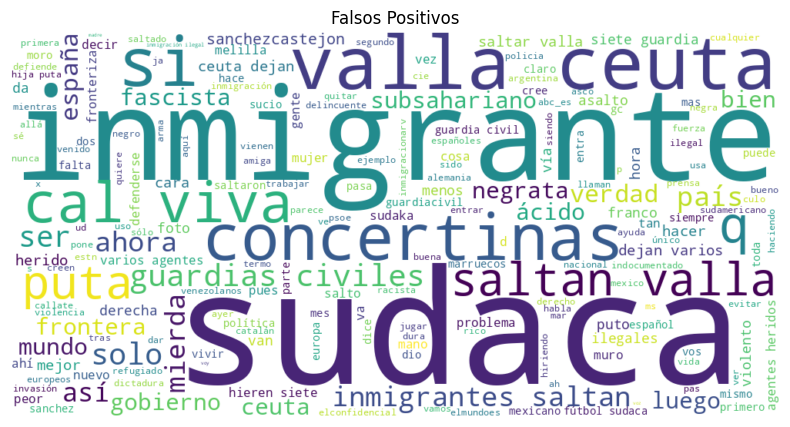

-----------------------------------
Falsos Negativos:
Las 25 palabras más comunes y su núm de apariciones:
[('puta', 62), ('inmigrantes', 22), ('ceuta', 22), ('valla', 20), ('concertinas', 17), ('callate', 14), ('``', 14), ("''", 12), ('cállate', 9), ('si', 9), ('madre', 9), ('ser', 9), ('guardias', 9), ('hijo', 8), ('mujer', 8), ('heridos', 8), ('hija', 7), ('q', 7), ('civiles', 7), ('200', 7), ('boca', 6), ('mereces', 6), ('...', 6), ('mierda', 5), ('muro', 5)]


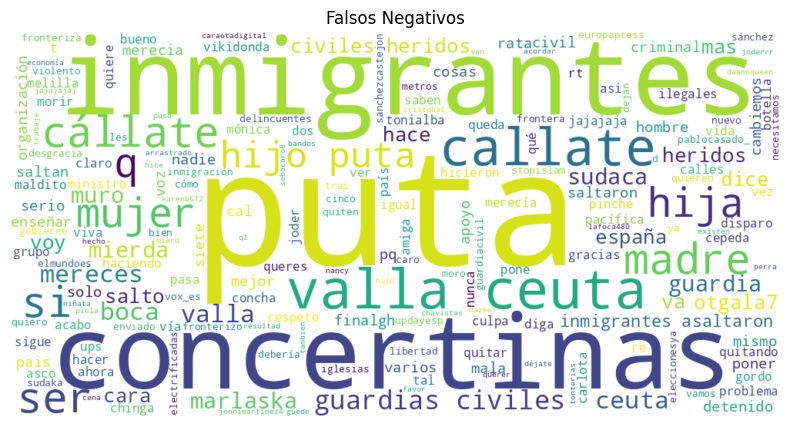

-----------------------------------
-----------------------------------

Ejemplos de Falsos Positivos:

Cuando le dices "puta" a una mujer es porque ya sientes algo por ella 🙊 lo sabían??
#holaputa Vs #holaputero. Las @TowandaRebels se equivocaron poniéndole voz a las TS. No son putas, ni les preguntar… https://t.co/G5JY9ZHUqi
Yo le hubiera dicho: “callate esa puta boca y manda foto de la traga venao” https://t.co/MHpbV6kRxS
Si tu eres tu puta, yo voy a ser el doble...🎶🎶🎶
@apauzocatorres Callate hija de puta
puta la madre, tu eres una mujer muy guapa @Camila_Cabello
O sea, ¿se supone que no puedo tener opiniones? ¿debo estar siempre callada porque soy una mujer? me dices puta por… https://t.co/vLjJccdNR4
a verga mardito que tenei con los maracuchos ps a q te pego la axila en la aspiradora esa q tenei en la cara
–Seguro andas de puta. Ésa fue la primera frase gacha que me dijo. Y a partr de entonces empezó a reinventarse. –… https://t.co/d57ufY1cXX
Entrar a jugar al CSGO, hablar y que a

AttributeError: 'NoneType' object has no attribute 'startswith'

In [26]:
df_test["predictions"] = df_robertuito["predictions"]
model_name = "robertuito"
print("-----------------------------------")
print("-----------------------------------")
print("-----------------------------------")

print(f"Evaluación para {model_name}:")

print("-----------------------------------")
print("-----------------------------------")
print("\nMétricas:\n")
metrics = evaluate_model(df_test)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1_score_macro']:.4f}")
plot_confusion_matrix(metrics['confusion_matrix'], model_name)


print("-----------------------------------")
print("-----------------------------------")
print("\nAnálisis de Sentimientos:\n")
sentiment_count = error_analysis_sentiment(df_test)
print("Sentimientos en Falsos Positivos:")
for sentiment, count in sentiment_count['FP'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("Sentimientos en Falsos Negativos:")
for sentiment, count in sentiment_count['FN'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("-----------------------------------")


print("\nAnálisis de Ironia:\n")
irony_count = error_analysis_irony(df_test)
print("Ironía en Falsos Positivos:")
for irony, count in irony_count['FP'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("Ironía en Falsos Negativos:")
for irony, count in irony_count['FN'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de Emocion:\n")
emotion_count = error_analysis_emotion(df_test)
print("Emociones en Falsos Positivos:")
for emotion, count in emotion_count['FP'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("Emociones en Falsos Negativos:")
for emotion, count in emotion_count['FN'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("-----------------------------------")








print("\nAnálisis de NER (Named Entity Recognition):\n")
ner_count = error_analysis_ner(df_test)
print("NER en Falsos Positivos:")
for ner, count in ner_count['FP'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("NER en Falsos Negativos:")
for ner, count in ner_count['FN'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nPalabras mas comunes y Wordcloud:\n")
print("Falsos Positivos:")
plot_wordcloud(df_test[(df_test['predictions'] == 1) & (df_test['hate_speech'] == 0)]['text'], 'Falsos Positivos')
print("-----------------------------------")
print("Falsos Negativos:")
plot_wordcloud(df_test[(df_test['predictions'] == 0) & (df_test['hate_speech'] == 1)]['text'], 'Falsos Negativos')
print("-----------------------------------")
print("-----------------------------------")




print("\nEjemplos de Falsos Positivos:\n")
for i in list(df_test[(df_test['predictions'] == 1) & (df_test['hate_speech'] == 0)]['text']):
      print(i)
print("\n-----------------------------------")
print("\nEjemplos de Falsos Negativos:")
for i in list(df_test[(df_test['predictions'] == 0) & (df_test['hate_speech'] == 1)]['text']):
    print(i)



print("\nAnálisis de POS (Parts of Speech):\n")
pos_count = error_analysis_pos(df_test)
print("POS en Falsos Positivos:")
for pos, count in pos_count['FP'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("POS en Falsos Negativos:")
for pos, count in pos_count['FN'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("-----------------------------------")

-----------------------------------
-----------------------------------
-----------------------------------
Evaluación para Robertuito 4 epoch:
-----------------------------------
-----------------------------------

Métricas:

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       940
           1       0.76      0.81      0.78       660

    accuracy                           0.81      1600
   macro avg       0.81      0.81      0.81      1600
weighted avg       0.82      0.81      0.82      1600

Accuracy: 0.8144
Precision: 0.7567
Recall: 0.8106
Macro F1 Score: 0.8104


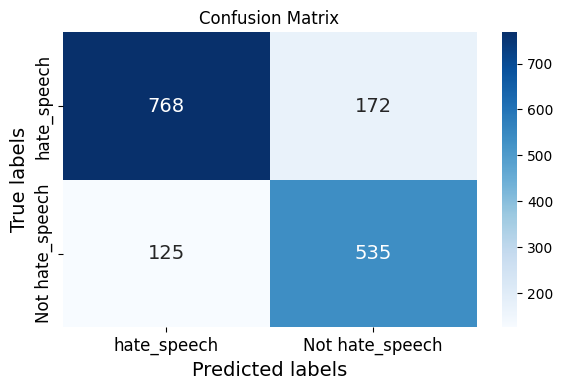

-----------------------------------
-----------------------------------

Análisis de Sentimientos:

Sentimientos en Falsos Positivos:
POS: 11
NEG: 128
NEU: 33
-----------------------------------
Sentimientos en Falsos Negativos:
NEG: 106
POS: 10
NEU: 9
-----------------------------------
-----------------------------------

Análisis de Ironia:

Ironía en Falsos Positivos:
ironic: 53
not ironic: 119
-----------------------------------
Ironía en Falsos Negativos:
not ironic: 106
ironic: 19
-----------------------------------
-----------------------------------

Análisis de Emocion:

Emociones en Falsos Positivos:
others: 79
anger: 83
joy: 7
surprise: 1
sadness: 2
-----------------------------------
Emociones en Falsos Negativos:
anger: 84
joy: 8
others: 30
sadness: 3
-----------------------------------
-----------------------------------

Análisis de NER (Named Entity Recognition):

NER en Falsos Positivos:
O: 5185
B-USER: 183
B-PER: 26
B-OTHER: 59
B-GROUP: 5
B-LOC: 83
I-LOC: 6
I-PER: 6


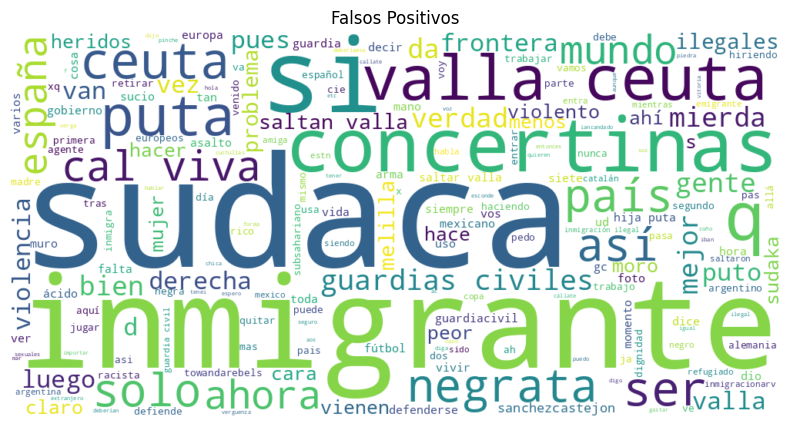

-----------------------------------
Falsos Negativos:
Las 25 palabras más comunes y su núm de apariciones:
[('puta', 60), ('inmigrantes', 37), ('ceuta', 32), ('valla', 30), ('concertinas', 17), ('callate', 16), ('``', 13), ("''", 12), ('guardias', 12), ('madre', 10), ('si', 10), ('civiles', 10), ('gobierno', 10), ('hijo', 9), ('mujer', 9), ('ser', 9), ('200', 9), ('cállate', 8), ('cal', 8), ('q', 8), ('boca', 7), ('mereces', 7), ('viva', 7), ('saltaron', 7), ('heridos', 7)]


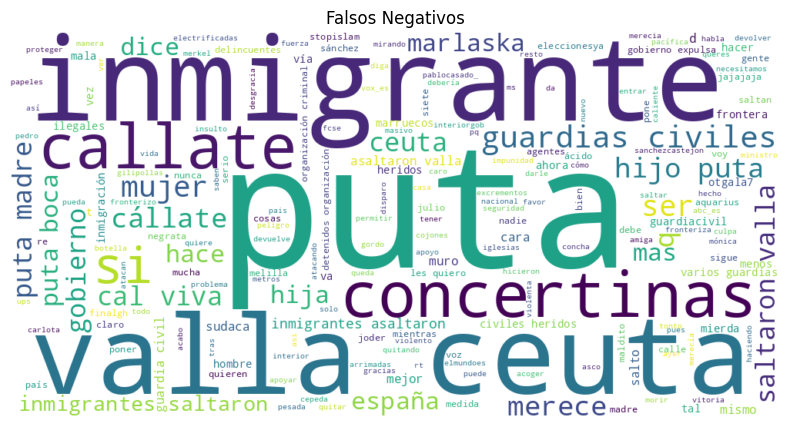

-----------------------------------
-----------------------------------

Ejemplos de Falsos Positivos:

Cuando le dices "puta" a una mujer es porque ya sientes algo por ella 🙊 lo sabían??
#holaputa Vs #holaputero. Las @TowandaRebels se equivocaron poniéndole voz a las TS. No son putas, ni les preguntar… https://t.co/G5JY9ZHUqi
@Zurine3 60% conocidos, 91'5% hombres
Si tu eres tu puta, yo voy a ser el doble...🎶🎶🎶
@apauzocatorres Callate hija de puta
puta la madre, tu eres una mujer muy guapa @Camila_Cabello
O sea, ¿se supone que no puedo tener opiniones? ¿debo estar siempre callada porque soy una mujer? me dices puta por… https://t.co/vLjJccdNR4
a verga mardito que tenei con los maracuchos ps a q te pego la axila en la aspiradora esa q tenei en la cara
–Seguro andas de puta. Ésa fue la primera frase gacha que me dijo. Y a partr de entonces empezó a reinventarse. –… https://t.co/d57ufY1cXX
Entrar a jugar al CSGO, hablar y que a partir de ahí solo escuche: cállate perra, guarra, etc. Así d

In [28]:
df_test["predictions"] = df_robertuito_4epoch["predictions"]
model_name = "Robertuito 4 epoch"


print("-----------------------------------")
print("-----------------------------------")
print("-----------------------------------")

print(f"Evaluación para {model_name}:")

print("-----------------------------------")
print("-----------------------------------")
print("\nMétricas:\n")
metrics = evaluate_model(df_test)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1_score_macro']:.4f}")
plot_confusion_matrix(metrics['confusion_matrix'], model_name)


print("-----------------------------------")
print("-----------------------------------")
print("\nAnálisis de Sentimientos:\n")
sentiment_count = error_analysis_sentiment(df_test)
print("Sentimientos en Falsos Positivos:")
for sentiment, count in sentiment_count['FP'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("Sentimientos en Falsos Negativos:")
for sentiment, count in sentiment_count['FN'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("-----------------------------------")


print("\nAnálisis de Ironia:\n")
irony_count = error_analysis_irony(df_test)
print("Ironía en Falsos Positivos:")
for irony, count in irony_count['FP'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("Ironía en Falsos Negativos:")
for irony, count in irony_count['FN'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de Emocion:\n")
emotion_count = error_analysis_emotion(df_test)
print("Emociones en Falsos Positivos:")
for emotion, count in emotion_count['FP'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("Emociones en Falsos Negativos:")
for emotion, count in emotion_count['FN'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("-----------------------------------")






print("\nAnálisis de NER (Named Entity Recognition):\n")
ner_count = error_analysis_ner(df_test)
print("NER en Falsos Positivos:")
for ner, count in ner_count['FP'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("NER en Falsos Negativos:")
for ner, count in ner_count['FN'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nPalabras mas comunes y Wordcloud:\n")
print("Falsos Positivos:")
plot_wordcloud(df_test[(df_test['predictions'] == 1) & (df_test['hate_speech'] == 0)]['text'], 'Falsos Positivos')
print("-----------------------------------")
print("Falsos Negativos:")
plot_wordcloud(df_test[(df_test['predictions'] == 0) & (df_test['hate_speech'] == 1)]['text'], 'Falsos Negativos')
print("-----------------------------------")
print("-----------------------------------")




print("\nEjemplos de Falsos Positivos:\n")
for i in list(df_test[(df_test['predictions'] == 1) & (df_test['hate_speech'] == 0)]['text']):
      print(i)
print("\n-----------------------------------")
print("\nEjemplos de Falsos Negativos:")
for i in list(df_test[(df_test['predictions'] == 0) & (df_test['hate_speech'] == 1)]['text']):
    print(i)



print("\nAnálisis de POS (Parts of Speech):\n")
pos_count = error_analysis_pos(df_test)
print("POS en Falsos Positivos:")
for pos, count in pos_count['FP'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("POS en Falsos Negativos:")
for pos, count in pos_count['FN'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("-----------------------------------")



-----------------------------------
-----------------------------------
-----------------------------------
Evaluación para Zero shot:
-----------------------------------
-----------------------------------

Métricas:

              precision    recall  f1-score   support

           0       0.94      0.70      0.80       940
           1       0.69      0.94      0.79       660

    accuracy                           0.80      1600
   macro avg       0.81      0.82      0.80      1600
weighted avg       0.84      0.80      0.80      1600

Accuracy: 0.7969
Precision: 0.6859
Recall: 0.9364
Macro F1 Score: 0.7968


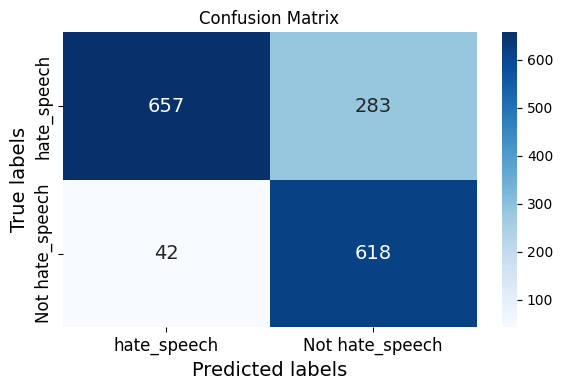

-----------------------------------
-----------------------------------

Análisis de Sentimientos:

Sentimientos en Falsos Positivos:
POS: 22
NEG: 203
NEU: 58
-----------------------------------
Sentimientos en Falsos Negativos:
NEG: 35
POS: 5
NEU: 2
-----------------------------------
-----------------------------------

Análisis de Ironia:

Ironía en Falsos Positivos:
ironic: 77
not ironic: 206
-----------------------------------
Ironía en Falsos Negativos:
not ironic: 36
ironic: 6
-----------------------------------
-----------------------------------

Análisis de Emocion:

Emociones en Falsos Positivos:
others: 123
anger: 138
joy: 18
surprise: 2
sadness: 2
-----------------------------------
Emociones en Falsos Negativos:
anger: 33
joy: 4
others: 4
sadness: 1
-----------------------------------
-----------------------------------

Análisis de POS (Parts of Speech):



AttributeError: 'NoneType' object has no attribute 'startswith'

In [29]:
df_test["predictions"] = df_zero_shot["predictions"]
model_name = "Zero shot"

print("-----------------------------------")
print("-----------------------------------")
print("-----------------------------------")

print(f"Evaluación para {model_name}:")

print("-----------------------------------")
print("-----------------------------------")
print("\nMétricas:\n")
metrics = evaluate_model(df_test)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1_score_macro']:.4f}")
plot_confusion_matrix(metrics['confusion_matrix'], model_name)


print("-----------------------------------")
print("-----------------------------------")
print("\nAnálisis de Sentimientos:\n")
sentiment_count = error_analysis_sentiment(df_test)
print("Sentimientos en Falsos Positivos:")
for sentiment, count in sentiment_count['FP'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("Sentimientos en Falsos Negativos:")
for sentiment, count in sentiment_count['FN'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("-----------------------------------")


print("\nAnálisis de Ironia:\n")
irony_count = error_analysis_irony(df_test)
print("Ironía en Falsos Positivos:")
for irony, count in irony_count['FP'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("Ironía en Falsos Negativos:")
for irony, count in irony_count['FN'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de Emocion:\n")
emotion_count = error_analysis_emotion(df_test)
print("Emociones en Falsos Positivos:")
for emotion, count in emotion_count['FP'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("Emociones en Falsos Negativos:")
for emotion, count in emotion_count['FN'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("-----------------------------------")




print("\nAnálisis de POS (Parts of Speech):\n")
pos_count = error_analysis_pos(df_test)
print("POS en Falsos Positivos:")
for pos, count in pos_count['FP'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("POS en Falsos Negativos:")
for pos, count in pos_count['FN'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de NER (Named Entity Recognition):\n")
ner_count = error_analysis_ner(df_test)
print("NER en Falsos Positivos:")
for ner, count in ner_count['FP'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("NER en Falsos Negativos:")
for ner, count in ner_count['FN'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nPalabras mas comunes y Wordcloud:\n")
print("Falsos Positivos:")
plot_wordcloud(df_test[(df_test['predictions'] == 1) & (df_test['hate_speech'] == 0)]['text'], 'Falsos Positivos')
print("-----------------------------------")
print("Falsos Negativos:")
plot_wordcloud(df_test[(df_test['predictions'] == 0) & (df_test['hate_speech'] == 1)]['text'], 'Falsos Negativos')
print("-----------------------------------")
print("-----------------------------------")




print("\nEjemplos de Falsos Positivos:\n")
for i in list(df_test[(df_test['predictions'] == 1) & (df_test['hate_speech'] == 0)]['text']):
      print(i)
print("\n-----------------------------------")
print("\nEjemplos de Falsos Negativos:")
for i in list(df_test[(df_test['predictions'] == 0) & (df_test['hate_speech'] == 1)]['text']):
    print(i)





In [24]:
results_summary = []

modelos = {
    "Robertuito": df_robertuito["predictions"],
    "Robertuito4epoch": df_robertuito_4epoch["predictions"],
    "Zero Shot": df_zero_shot["predictions"],
}

y_true = df_test["hate_speech"]

for nombre_modelo, y_pred in modelos.items():
    errores = (y_true != y_pred).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()

    fp_pct = 100 * fp / errores if errores > 0 else 0
    fn_pct = 100 * fn / errores if errores > 0 else 0

    results_summary.append({
        "Model": nombre_modelo,
        "Total Errors": errores,
        "FP (Count)": fp,
        "FP (%)": f"{fp_pct:.2f}%",
        "FN (Count)": fn,
        "FN (%)": f"{fn_pct:.2f}%"
    })

summary_df = pd.DataFrame(results_summary)

import pandas as pd
from tabulate import tabulate

print("\nTabla resumen de errores por modelo:\n")
print(tabulate(summary_df, headers='keys', tablefmt='github'))

summary_df.to_csv("summary_errors.csv", index=False)



Tabla resumen de errores por modelo:

|    | Model            |   Total Errors |   FP (Count) | FP (%)   |   FN (Count) | FN (%)   |
|----|------------------|----------------|--------------|----------|--------------|----------|
|  0 | Robertuito       |            297 |          185 | 62.29%   |          112 | 37.71%   |
|  1 | Robertuito4epoch |            297 |          172 | 57.91%   |          125 | 42.09%   |
|  2 | Zero Shot        |            325 |          283 | 87.08%   |           42 | 12.92%   |


In [ ]:
y_pred_fs = df_robertuito["predictions"]
y_pred_rb = df_robertuito_4epoch["predictions"]
y_pred_ro = df_zero_shot["predictions"]

y_true = df_test["hate_speech"]

errors_fs = y_pred_fs != y_true
errors_rb = y_pred_rb != y_true
errors_ro = y_pred_ro != y_true

common_errors = errors_fs & errors_rb & errors_ro
num_common_errors = common_errors.sum()

fp_common = ((y_pred_fs == 1) & (y_true == 0) & common_errors).sum()
fn_common = ((y_pred_fs == 0) & (y_true == 1) & common_errors).sum()

fp_common_pct = 100 * fp_common / num_common_errors if num_common_errors > 0 else 0
fn_common_pct = 100 * fn_common / num_common_errors if num_common_errors > 0 else 0

results_summary.append({
    "Model": "All (in common)",
    "Total Errors": num_common_errors,
    "FP (Count)": fp_common,
    "FP (%)": f"{fp_common_pct:.2f}%",
    "FN (Count)": fn_common,
    "FN (%)": f"{fn_common_pct:.2f}%"
})

summary_df = pd.DataFrame(results_summary)
print("\nTabla con errores comunes:\n")
print(tabulate(summary_df, headers="keys", tablefmt="github"))



Tabla con errores comunes añadida:

|    | Model            |   Total Errors |   FP (Count) | FP (%)   |   FN (Count) | FN (%)   |
|----|------------------|----------------|--------------|----------|--------------|----------|
|  0 | Robertuito       |            297 |          185 | 62.29%   |          112 | 37.71%   |
|  1 | Robertuito4epoch |            297 |          172 | 57.91%   |          125 | 42.09%   |
|  2 | Zero Shot        |            325 |          283 | 87.08%   |           42 | 12.92%   |
|  3 | All (in common)  |            144 |          118 | 81.94%   |           26 | 18.06%   |
